# Project Notebook - Machine Learning I

### Libraries

In [1]:
import pandas as pd
import numpy as np
import openml
from AdaBoostWorkyWorky import AdaBoost
from sklearn.model_selection import KFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import scipy.stats as ss
import matplotlib.pyplot as plt


### Get the datasets to use throughout the project

Function to read a dataset from [OpenML-CC18 Curated Classification benchmark](https://www.openml.org/search?type=study&sort=tasks_included&study_type=task&id=99) givent its Task ID and return the corresponding Pandas Dataframe

In [2]:
def getDataset(task_id):
    suite = openml.study.get_suite(99)
    task = openml.tasks.get_task(task_id)    
    dataset = openml.datasets.get_dataset(task.dataset_id)

    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )

    df = pd.DataFrame(X, columns=attribute_names)
    # converter:
    #   0 -> -1
    #   1 -> 1
    df['target'] = 2*y-1 
    # erase rows with NaN values
    df = df.dropna(how='any', axis=0)

    return df

Description of the datasets used in this project:
- A
- B
- C

In [3]:
datasets = [
    ("Task ID = 15", getDataset(15)),
    ("Task ID = 24", getDataset(24)),
    ("Task ID = 3904", getDataset(3904))
]

### Performance evaluation of AdaBoost

In [4]:
# function to perform cross validation on a set of algorithms ("algs")
def run_cv(X,y,algs,nfolds=10):
    results = {}
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=1111)
    for algo_name, algo in algs:
        results[algo_name] = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            algo.fit(X_train, y_train)
            y_pred = algo.predict(X_test)
            results[algo_name].append(accuracy_score(y_test, y_pred))
    results_df = pd.DataFrame.from_dict(results)
    return results_df

In [5]:
# running 10-fold cross validation for all datasets and checking accuracy

for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    algs = [("AdaBoost", AdaBoost())]
    result = run_cv(X, y, algs)
    print(f"Mean accuracy for dataset wiht {ds_id} in 10-fold CV: {np.mean(result['AdaBoost']):.5f}")

Mean accuracy for dataset wiht Task ID = 15 in 10-fold CV: 0.95757
Mean accuracy for dataset wiht Task ID = 24 in 10-fold CV: 0.97591
Mean accuracy for dataset wiht Task ID = 3904 in 10-fold CV: 0.81103


In [6]:
# function to plot the Confusion Matrix of a fitted model
def plot_cm(model_fit,X_test,y_test):
    y_pred = model_fit.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

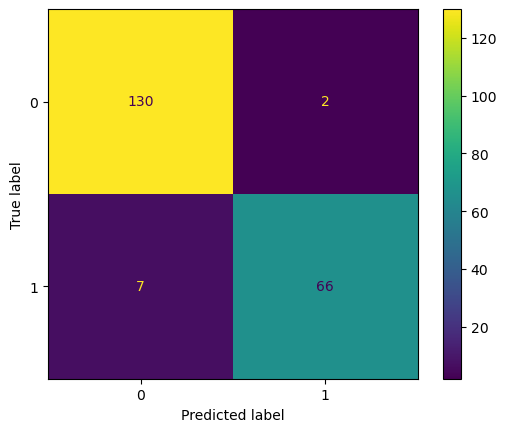

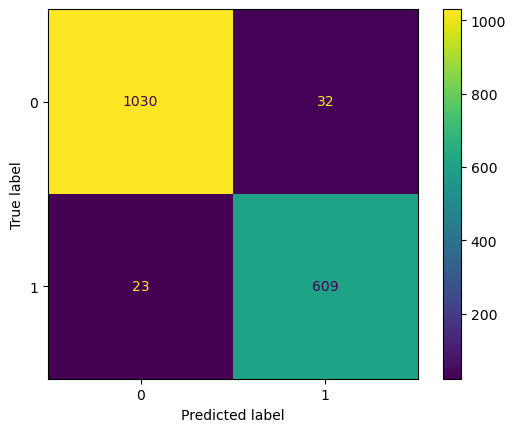

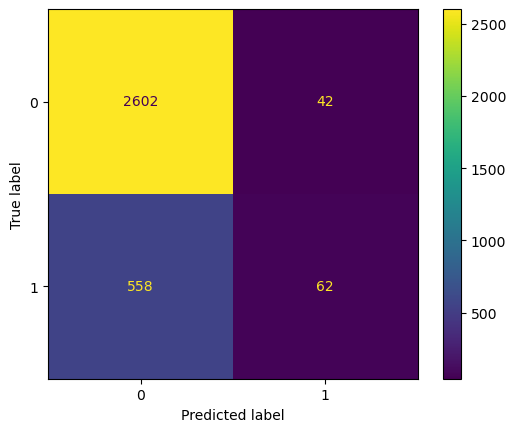

In [7]:
# confusion matrix for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    ab = AdaBoost()
    ab.fit(X_train, y_train)
    plot_cm(ab, X_test, y_test)


In [8]:
# unable to test ROC Curve because our implementation doesnt have a "predict_proba" method

In [9]:
# function to plot the Learning Curve of a fitted model
def plot_learning_curves(model, X, y, title=''):
    training_size = np.linspace(0.1,1.0,10)

    train_scores = {}
    test_scores = {}
    for tr_size in training_size:
        train_scores[tr_size] = []
        test_scores[tr_size] = []
        # run 10 tests with training size = tr_size and store all accuracy results in a line of train_scores and test_scores
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=tr_size)
            model.fit(X_train, y_train)
            training_pred = model.predict(X_train)
            testing_pred = model.predict(X_test)
            train_scores[tr_size].append(accuracy_score(training_pred, y_train))
            test_scores[tr_size].append(accuracy_score(testing_pred, y_test))
        # print some statistics
        print(
            f"Train size: {tr_size}\n \
            Mean training score: {round(np.mean(train_scores[tr_size]), 5)}\n \
            Standard deviation: {round(np.std(train_scores[tr_size]), 5)}"
        )

    train_mean = [np.mean(train_scores[tr_size]) for tr_size in training_size]
    train_std = [np.std(train_scores[tr_size]) for tr_size in training_size]
    test_mean = [np.mean(test_scores[tr_size]) for tr_size in training_size]
    test_std = [np.std(test_scores[tr_size]) for tr_size in training_size]

    plt.figure(figsize=(8, 6))
    plt.plot(training_size, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(training_size, test_mean, 'o-', color='green', label='Test score')
    plt.fill_between(training_size, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(training_size, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Learning Curves '+title)
    plt.show()


In [10]:
# ROC Cruve for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    ab = AdaBoost()
    plot_learning_curves(ab, X, y, title="AdaBoost")

Train size: 0.1
             Mean training score: 1.0
             Standard deviation: 0.0
Train size: 0.2
             Mean training score: 0.99779
             Standard deviation: 0.00471
Train size: 0.30000000000000004
             Mean training score: 0.99216
             Standard deviation: 0.01122
Train size: 0.4
             Mean training score: 0.98352
             Standard deviation: 0.00441
Train size: 0.5
             Mean training score: 0.97742
             Standard deviation: 0.00919
Train size: 0.6
             Mean training score: 0.97971
             Standard deviation: 0.01049
Train size: 0.7000000000000001
             Mean training score: 0.97636
             Standard deviation: 0.00743
Train size: 0.8
             Mean training score: 0.97326
             Standard deviation: 0.0063
Train size: 0.9
             Mean training score: 0.9684
             Standard deviation: 0.00438


ValueError: train_size=1.0 should be either positive and smaller than the number of samples 683 or a float in the (0, 1) range